# Model (2022-06-29)
Today we will:
- Be more careful of the garbage going in, and 
- More closely diagnose the garbage coming out

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from isochrones import get_ichrone
from scipy import stats


from sbi import utils
from sbi import analysis
from sbi.inference.base import infer

/Users/arc/anaconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
# First, some settings.
from sbi.inference import SNPE as method

num_simulations = 50_000
num_samples = 10_000

labels = ("M1", "q", "age", "[M/H]")

bounds = np.array([
    [0.5,  1.8], # M1
    [0,      1], # q
    [0.2,   10], # (Gyr)
    [-1.5, 0.5]  # metallicity
])

In [3]:
# Define simulator

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(m1, q, age, fe_h):
    # isochrones.py needs log10(Age [yr]). 
    # Our age is in Gyr, so we take log10(age * 10^9) = log10(age) + 9
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9, 
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values 
    r_mag = properties.RP_mag.values
    return np.array([b_mag, r_mag, g_mag]).T

def simulator(theta):
    return torch.tensor(binary_color_mag_isochrones(*theta))

In [4]:
# Set priors.
from torch.distributions import (Uniform, Beta, Pareto)
from torch.distributions.transforms import AffineTransform
from torch.distributions.transformed_distribution import TransformedDistribution

from torch import tensor as tt

# This doesn't quite work yet:
# https://github.com/mackelab/sbi/issues/680
prior = [
    TransformedDistribution(
        Pareto(scale=tt([1.]), alpha=tt([5.])),
        AffineTransform(loc=tt([0.8]), scale=tt([1.]))
    ), 
    Uniform(tt([0.]), tt([1.])), 
    Uniform(tt([1.]), tt([10.])),
    TransformedDistribution(
        Beta(tt([10.]), tt([2.])), 
        AffineTransform(
            loc=tt([-1.5]), 
            scale=tt([0.5])
        )
    )
]
 
# So instead we will use something dumber:
prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

In [72]:
'''
class Prior:
    def __init__(self, m1_b=5, m1_min=0.8):
        alpha, beta = (10, 2)        
        self.distributions = [
            stats.pareto(b=m1_b, loc=1 - m1_min), # m1
            stats.uniform(*bounds[1]), # q
            stats.uniform(*bounds[2]), # age
            stats.beta(
                alpha, 
                beta, 
                loc=bounds[3, 0], 
                scale=bounds[3, 1] - bounds[3, 0]
            )
        ]
    
    def sample(self, sample_shape=torch.Size([])):
        return torch.tensor(np.array([d.rvs(sample_shape) for d in self.distributions])).T
    
    def log_prob(self, value):
        log_probs = np.array([d.logpdf(v) for d, v in zip(self.distributions, value)])
        return torch.tensor(np.sum(log_probs, axis=1))
'''

'\nclass Prior:\n    def __init__(self, m1_b=5, m1_min=0.8):\n        alpha, beta = (10, 2)        \n        self.distributions = [\n            stats.pareto(b=m1_b, loc=1 - m1_min), # m1\n            stats.uniform(*bounds[1]), # q\n            stats.uniform(*bounds[2]), # age\n            stats.beta(\n                alpha, \n                beta, \n                loc=bounds[3, 0], \n                scale=bounds[3, 1] - bounds[3, 0]\n            )\n        ]\n    \n    def sample(self, sample_shape=torch.Size([])):\n        return torch.tensor(np.array([d.rvs(sample_shape) for d in self.distributions])).T\n    \n    def log_prob(self, value):\n        log_probs = np.array([d.logpdf(v) for d, v in zip(self.distributions, value)])\n        return torch.tensor(np.sum(log_probs, axis=1))\n'

In [5]:
from sbi.inference import prepare_for_sbi, simulate_for_sbi

sbi_simulator, sbi_prior = prepare_for_sbi(simulator, prior)

inference = method(prior)

In [9]:
# Generate the simulations. 
# We do this ourselves (instead of using simulate_for_sbi) because if we don't then many will be NaNs
# and we end up with fewer simulations than we want.

def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
    num_trials, num_simulated, theta, x = (0, 0, [], [])
    while num_simulated < num_simulations:
        N = num_simulations - num_simulated
        print(f"Running {N} simulations")
        _theta = proposal.sample((N, ))
        _x = simulator(_theta)
        #_theta, _x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=N)
        keep = np.all(np.isfinite(_x).numpy(), axis=1)
        theta.extend(np.array(_theta[keep]))
        x.extend(np.array(_x[keep]))
        num_trials += 1
        num_simulated += sum(keep)
        if num_trials > max_trials:
            print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
            break
    theta = torch.tensor(np.vstack(theta))
    x = torch.tensor(np.vstack(x))
    return (theta, x)
            
theta, x = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_simulations)

Running 3 simulations.: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 143.10it/s]


In [10]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 153 epochs.

In [11]:
posterior = inference.build_posterior(density_estimator)

tensor([[3.8977, 3.3120, 3.6829]], dtype=torch.float64)


/var/folders/44/c9tlrlp90d3dgyhpzcjhz9vc0000gn/T/ipykernel_50211/2701133629.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(observation),


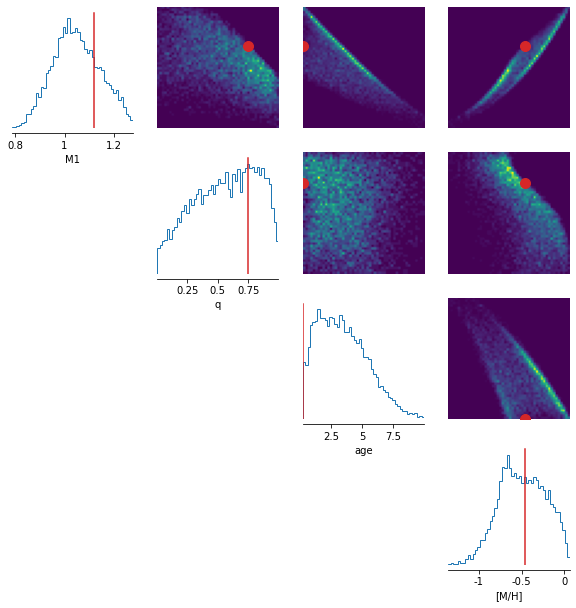

In [12]:
# mass, q, age, metallicity
truth = np.array([1.120, 0.75, 0.215, -0.463])
observation = simulator(truth)
print(observation)
assert np.all(np.isfinite(np.array(observation)))
samples = posterior.sample(
    (num_samples,), 
    x=torch.tensor(observation),
    show_progress_bars=False
)
fig = analysis.pairplot(
    samples, 
    points=truth,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

In [13]:
# Now let's do a little injection and recovery test.
num_injections = 100
true_theta, true_obs = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_injections)

Running 2 simulations.: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 143.86it/s]


In [14]:
# Do sampling for each one.
from tqdm import tqdm
_, L = sbi_prior.sample((1, )).shape

all_samples = np.empty((num_injections, num_samples, L))
for i, obs in enumerate(tqdm(true_obs)):
    all_samples[i] = posterior.sample(
        (num_samples,), 
        x=obs,
        show_progress_bars=False
    )

100%|███████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.21it/s]


In [105]:
# Let's see where the truth was as a percentile in each injection.

In [107]:
all_samples[0].shape

(10000, 4)

In [17]:
from scipy.stats import percentileofscore as pos
true_theta = np.array(true_theta)

percentiles = np.empty((num_injections, L))
for i, this_theta in enumerate(tqdm(np.array(true_theta))):
    for j, t in enumerate(this_theta):
        percentiles[i, j] = pos(all_samples[i, :, j], t)
        

100%|█████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5435.92it/s]


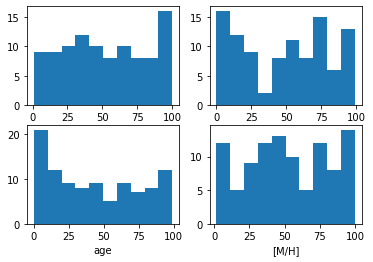

In [18]:
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.hist(percentiles[:, i])
    ax.set_xlabel(labels[i])

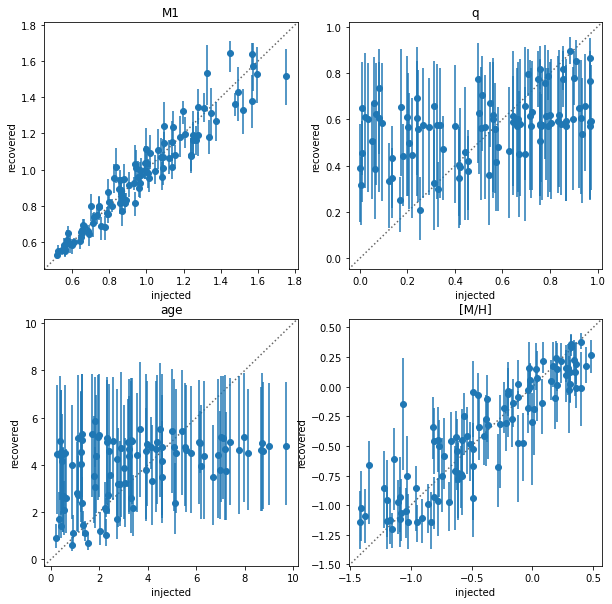

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    lower, mean, upper = np.percentile(all_samples[:, :, i], [16, 50, 84], axis=1)
    yerr_pos = upper - mean
    yerr_neg = mean - lower
    ax.errorbar(
        true_theta[:, i],
        mean,
        yerr=(yerr_neg, yerr_pos),
        fmt='o'
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", ls=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(f"injected")
    ax.set_ylabel(f"recovered")


(0.0, 1.0)

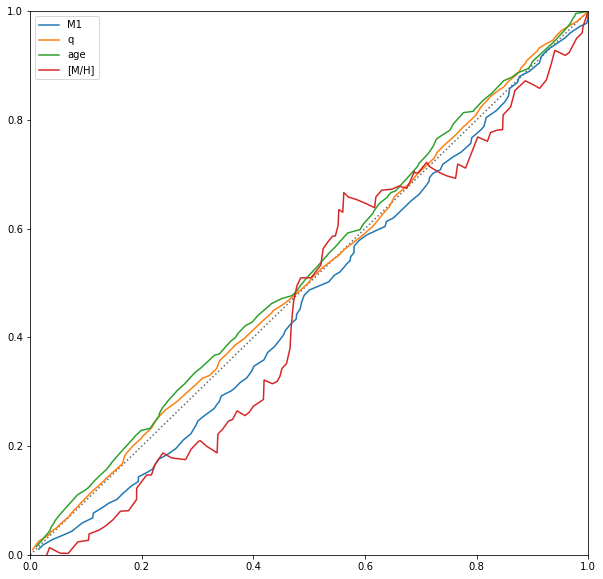

In [21]:
## TODO: Check that this is the right thing to be doing here!
fig, ax = plt.subplots(figsize=(10, 10))

for i, label in enumerate(labels):
    x = percentiles.T[i]
    y = true_theta.T[i]
    ax.plot(
        np.cumsum(x)/np.sum(x),
        np.cumsum(y)/np.sum(y),
        label=label
    )
limits = [0, 1]
ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
ax.legend()
ax.set_xlim(limits)
ax.set_ylim(limits)

Text(0.5, 1.0, 'Injection set')

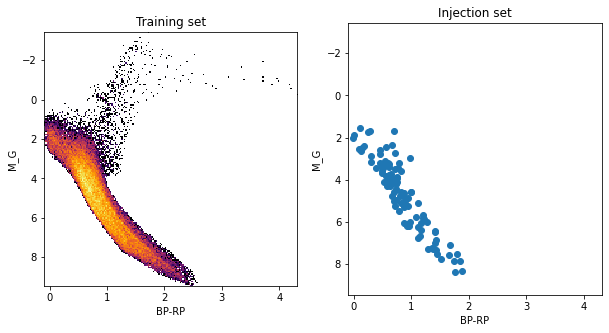

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

from matplotlib.colors import LogNorm 
def plot_binned_statistic(x, y, z, bins=100, function=np.nanmedian,
                          xlabel=None, ylabel=None, zlabel=None,
                          ax=None, colorbar=False, figsize=(8, 8),
                          vmin=None, vmax=None, min_entries_per_bin=None,
                          subsample=None, mask=None, full_output=False, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    
    finite = np.isfinite(x * y * z)
    if mask is not None:
        finite *= mask
    if subsample is not None:
        idx = np.where(finite)[0]
        if subsample < 1:
            subsample *= idx.size
        if int(subsample) > idx.size:
            finite = idx
        else:
            finite = np.random.choice(idx, int(subsample), replace=False)
    
    H, xedges, yedges, binnumber = binned_statistic_2d(
        x[finite], y[finite], z[finite],
        statistic=function, bins=bins)

    if min_entries_per_bin is not None:
        if function != "count":
            H_count, xedges, yedges, binnumber = binned_statistic_2d(
                x[finite], y[finite], z[finite],
                statistic="count", bins=bins)

        else:
            H_count = H

        H[H_count < min_entries_per_bin] = np.nan


    if (vmin is None or vmax is None) and "norm" not in kwargs:
        vmin_default, med, vmax_default = np.nanpercentile(H, kwargs.pop("norm_percentiles", [5, 50, 95]))
        if vmin is None:
            vmin = vmin_default
        if vmax is None:
            vmax = vmax_default
    
    imshow_kwds = dict(
        vmin=vmin, vmax=vmax,
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
        interpolation="bilinear")
    imshow_kwds.update(kwargs)
    
    image = ax.imshow(H.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image, ax=ax)
        if zlabel is not None:
            cbar.set_label(zlabel)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    #fig.tight_layout()

    return (fig, image) if full_output else fig


# Plot the training set and the injection set in data coords
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# b, r, g
c_index = 1 # q
c = x.T[c_index]
vmin, vmax = (min(c), max(c))
plot_binned_statistic(
    np.array(x.T[0] - x.T[1]),
    np.array(x.T[2]),
    np.array(x.T[2]),
    norm=LogNorm(),
    function="count",
    min_entries_per_bin=1,
    interpolation="nearest",
    bins=200,
    ax=axes[0]
)

axes[1].scatter(
    true_obs.T[0] - true_obs.T[1],
    true_obs.T[2],
)
for ax in axes:
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("M_G")
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[0].set_title("Training set")
axes[1].set_title("Injection set")

In [46]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
bad_index = np.argmax(delta_q)
bad_theta = true_theta[bad_index]
print(bad_theta)

[0.7767528  0.0075224  1.9850544  0.40218234]


(100, 10000, 4)


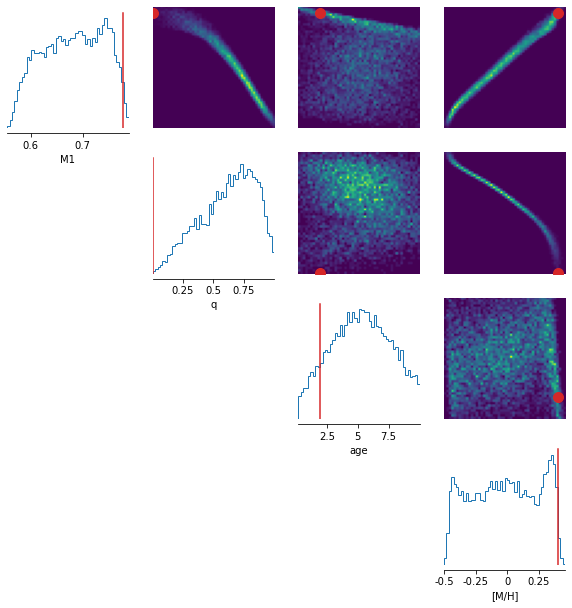

In [48]:
print(all_samples.shape)
fig = analysis.pairplot(
    all_samples[bad_index], 
    points=bad_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

In [49]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
good_index = np.argmin(delta_q)
good_theta = true_theta[good_index]
print(good_theta)

[0.73364866 0.78960204 9.70575    0.16762304]


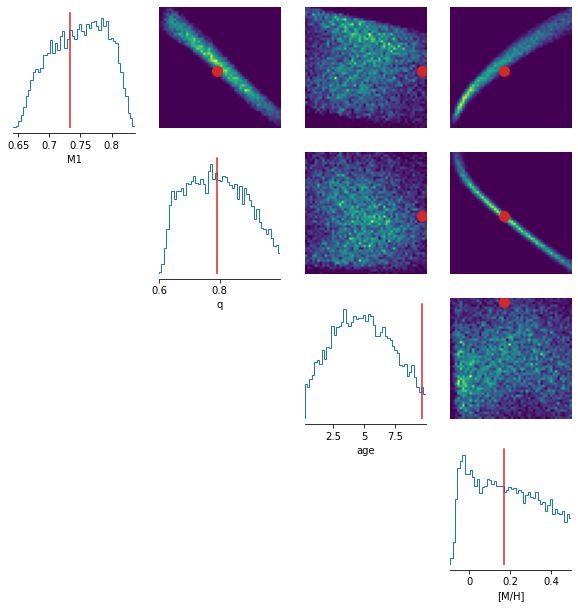

In [50]:
fig = analysis.pairplot(
    all_samples[good_index], 
    points=good_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)